# Control theory and Vicsek Model - Clustering data

# Import libraries

In [220]:
# General imports
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from IPython.display import Video, display

In [221]:
# Module imports
import models.vicsek as vicsek
import visualisation as visualisation
import utils
import animation.Animator2D as Animator2D
import animation.MatplotlibAnimator as MatplotlibAnimator

# Launching a simulation 

In [222]:
# Initialize the Vicsek model.
radius = 2
L = 50
N = 300


In [223]:
simulator = vicsek.Vicsek(numberOfParticles=N, domainSize=(L, L), radius=radius)
# Simulate the Vicsek model.
simulationData = simulator.simulate()

# Extract the simulation data.
# time, positions, orientations = simulationData[0], simulationData[1], simulationData[2]

In [224]:
df = utils.simulationDataToDataframe(simulationData)
df.head()

,t,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,theta_x_295,theta_y_295,theta_x_296,theta_y_296,theta_x_297,theta_y_297,theta_x_298,theta_y_298,theta_x_299,theta_y_299
0,0.0,11.061103,23.994821,35.285038,31.737040,25.935000,47.330001,10.366197,12.402211,37.125838,...,-0.346192,0.938164,-0.475840,0.879532,-0.950641,-0.310292,-0.969174,0.246379,-0.133272,-0.991079
1,0.5,11.559197,24.038438,35.701628,32.013540,25.534935,47.030088,10.526173,11.928494,37.478222,...,-0.495951,0.868351,-0.081212,0.996697,-0.995966,-0.089728,-0.648489,0.761224,0.061109,-0.998131
2,1.0,12.041858,24.168968,35.883806,32.479170,25.036059,46.996585,10.640938,11.441843,37.145423,...,0.085648,0.996325,0.566027,0.824387,-0.991988,-0.126331,-0.552949,0.833215,0.343716,-0.939074
3,1.5,12.540249,24.209046,36.336311,32.691864,24.553683,46.865006,10.678881,10.943285,36.794399,...,-0.318812,0.947818,0.496032,0.868304,-0.974194,-0.225711,-0.939661,0.342107,0.002518,-0.999997
4,2.0,12.430212,24.696788,36.726174,32.378805,24.057372,46.804380,10.920565,10.505576,36.733147,...,0.741719,0.670711,0.998661,0.051737,-0.764517,-0.644604,-0.875772,0.482724,0.235268,-0.971930


In [225]:
# # Initialize the Matplotanimator and feed the simulation data and domain size.
# animator = MatplotlibAnimator.MatplotlibAnimator(simulationData, (50,50))
# # Prepare the animator for a 2D representation.
# preparedAnimator = animator.prepare(Animator2D.Animator2D())
# preparedAnimator.saveAnimation('data/vicsek_test.mp4')

In [226]:
# display(Video('data/vicsek_test.mp4', embed=False))

# Clustering analysis

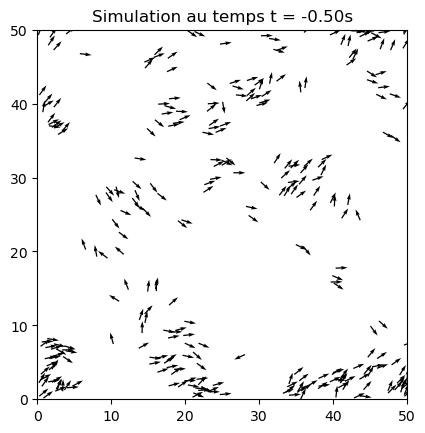

In [227]:
fig, ax = visualisation.plot_simulation(df, -1, L)
plt.show()

## Clustering scaled data without periodic conditions 

In [228]:
### TESTS
pos_labels = utils.naive_clustering_labels_positions(df, -1)
orient_labels = utils.naive_clustering_labels_orientations(df, -1)
all_labels = utils.naive_clustering_labels_positions_and_orientations(df, -1)

for label, text in zip([pos_labels, orient_labels, all_labels], ["positions", "orientations", "positions and orientations"]):
    n_clust, n_noise = utils.clustering_labels_stats(label)
    print(f"{text}: Number of clusters: {n_clust}, number of noise points: {n_noise}")


positions: Number of clusters: 5, number of noise points: 7
orientations: Number of clusters: 1, number of noise points: 5
positions and orientations: Number of clusters: 13, number of noise points: 175


c:\Users\nicos\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


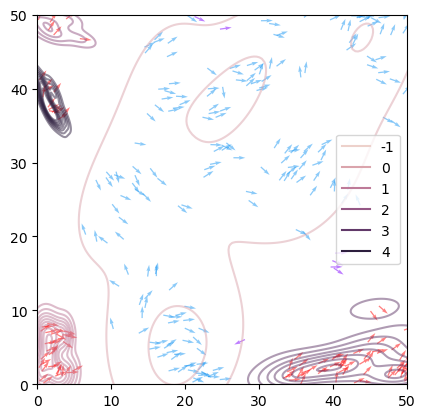

c:\Users\nicos\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


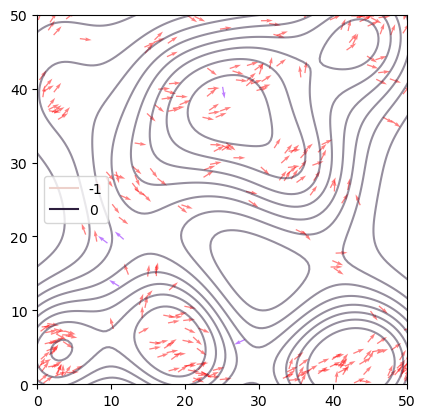

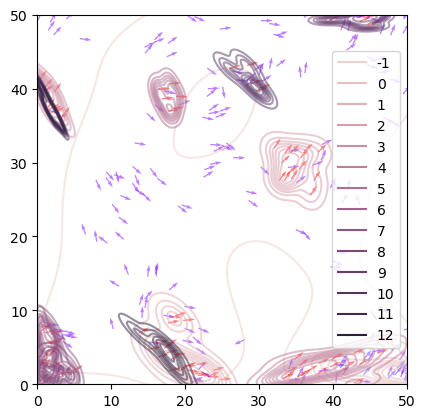

In [229]:
fig, ax = visualisation.plot_clusters_kde(df, -1, custom_labels=pos_labels)
fig, ax = visualisation.plot_clusters_kde(df, -1, custom_labels=orient_labels)
fig, ax = visualisation.plot_clusters_kde(df, -1, custom_labels=all_labels)

plt.show()

This method is very sensitive to clusters with different densities. This is why it must be calibrated "by hand". We can try to implement a clustering method which uses data that are not scaled. 

## Clustering with unscaled data and without periodic boundaries 

In [230]:
def clustering_labels_positions(df, i, k_coef, rho, min_samples=5):
    df_pos = utils.get_positions(df, i)
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_pos = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_pos)
    return db_pos.labels_

def clustering_labels_angles(df, i, delta_theta, N, k_coef):
    df_angle = utils.get_angles(df, i)
    min_sample = np.ceil(k_coef * N * delta_theta / (2 * np.pi))
    db_angle = cluster.DBSCAN(eps=delta_theta/2, min_samples=min_sample).fit(df_angle.to_numpy().reshape(-1, 1))
    return db_angle.labels_

def clustering_labels_velocities(df, i, k_coef, N, min_samples=5):
    df_vel = utils.get_orientations(df, i)
    rho = N / 4
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_vel = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_vel)
    return db_vel.labels_

def clustering_labels_positions_and_orientations(df, i, k_coef, rho, min_samples=5):
    df_all = utils.get_positions_and_angles(df, i)
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    db_all = cluster.DBSCAN(eps=threshold, min_samples=min_samples).fit(df_all)
    return db_all.labels_

c:\Users\nicos\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


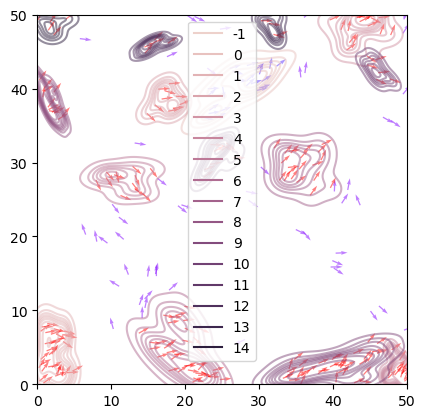

In [231]:
pos_labels = clustering_labels_positions(df, -1, k_coef=2, rho=N/(L**2), min_samples=5)
visualisation.plot_clusters_kde(df, -1, custom_labels=pos_labels)
plt.show()

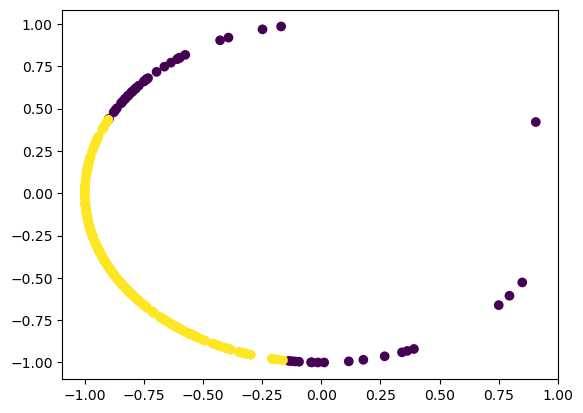

In [232]:
ang_labels = clustering_labels_angles(df, -1, np.pi/6., N, 2)
# fig, ax = visualisation.plot_clusters(df, -1, custom_labels=ang_labels)
df_ang = utils.get_angles(df, -1)
plt.scatter(np.cos(df_ang), np.sin(df_ang), c=ang_labels)
plt.show()

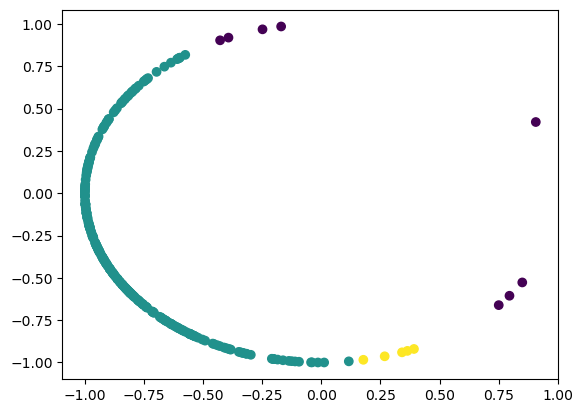

In [233]:
vel_labels = clustering_labels_velocities(df, -1, k_coef = 1, N=N, min_samples=5)
df_ang = utils.get_angles(df, -1)
plt.scatter(np.cos(df_ang), np.sin(df_ang), c=vel_labels)
plt.show()


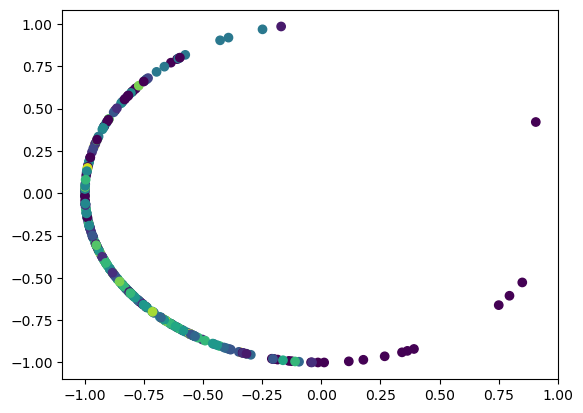

In [234]:
df_ang = utils.get_angles(df, -1)
plt.scatter(np.cos(df_ang), np.sin(df_ang), c=pos_labels)
plt.show()

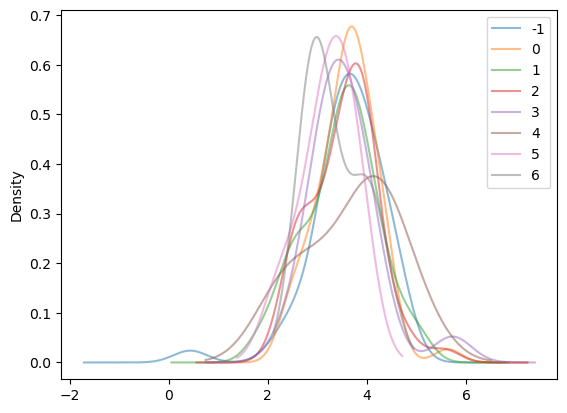

In [241]:
df_ang = utils.get_angles(df, -1)
# dataframe with angles, labels
df_ang = pd.DataFrame({'angle': df_ang, 'label': pos_labels})
# density by label 
df_ang.groupby('label').angle.plot(kind='kde', legend=True, alpha=0.5)
plt.show()

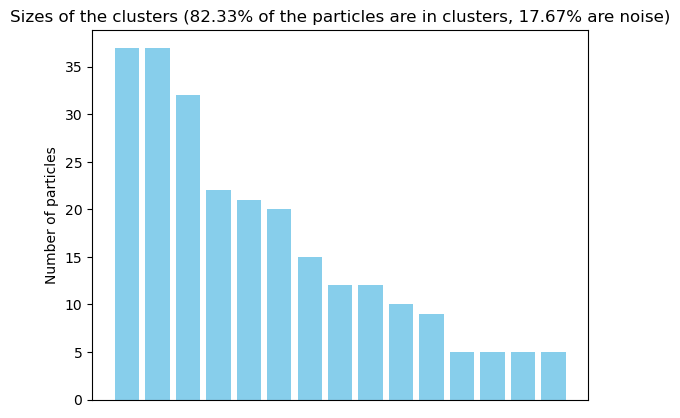

In [236]:
n_cl, n_noise = utils.clustering_labels_stats(pos_labels)
percent_cl, percent_noise = (N - n_noise)/N, n_noise/N 
cluster_counts = pd.DataFrame(pos_labels, columns=["etiquette"]) \
    .where(pd.DataFrame(pos_labels, columns=["etiquette"])["etiquette"] != -1).value_counts().to_numpy()
plt.bar(range(len(cluster_counts)), cluster_counts, color='skyblue')
plt.title(f"Sizes of the clusters ({percent_cl* 100:.2f}% of the particles are in clusters, {percent_noise* 100:.2f}% are noise)")
plt.ylabel("Number of particles")
plt.xticks([])
plt.show()

In [237]:
n_cl, n_noise = utils.clustering_labels_stats(pos_labels)
print(f"Number of clusters: {n_cl}, number of noise points: {n_noise}")
print(f'Particles in clusters: {N-n_noise}, noise particles: {n_noise}')
print(f'Percentage of particles in clusters: {(N-n_noise)/N*100:.2f}%')
print(f'Percentage of noise particles: {n_noise/N*100:.2f}%')

Number of clusters: 15, number of noise points: 53
Particles in clusters: 247, noise particles: 53
Percentage of particles in clusters: 82.33%
Percentage of noise particles: 17.67%


The best one is with **position only** !  

## Clustering with unscaled data and with periodic boundaries 

In [238]:
from numba import jit

In [291]:
# Position matrix
# @jit(nopython=True)
def distance_periodic(X, Y, periods):
    dims = periods.shape[0]
    n = X.shape[0]
    dist = 0 
    for d in range(dims):
        delta = np.abs(X[d] - Y[d])
        if delta > periods[d] / 2:
            delta = periods[d] - delta
        dist += (delta)**2
    return np.sqrt(dist)

In [292]:
point = np.array([10, 10])
periods = np.array([50, 50])
X, Y = np.arange(50), np.arange(50)


In [293]:
Z = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        point2 = np.array([X[i], Y[j]])
        # print(point2)
        Z[i,j] = distance_periodic(X = point, Y = point2, periods=periods)



In [294]:

Xmes, Ymesh = np.meshgrid(X, Y)
Zmesh = np.sqrt((Xmes - point[0])**2 + (Ymesh - point[1])**2)



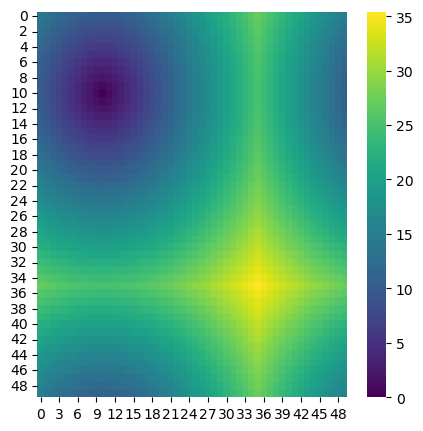

<AxesSubplot:>

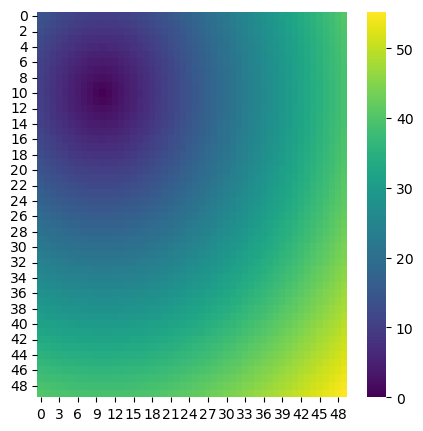

In [296]:

# heatmap 
plt.figure(figsize=(5,5))
sns.heatmap(Z, cmap='viridis')
plt.show()

plt.figure(figsize=(5,5))
sns.heatmap(Zmesh, cmap='viridis')

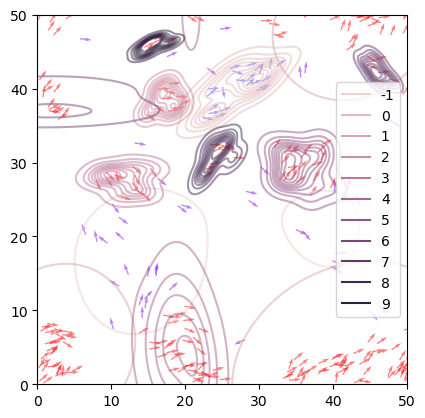

c:\Users\nicos\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


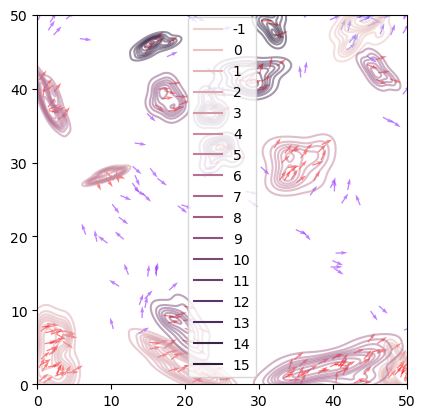

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [298]:
def periodic_clustering_labels_positions(df, i, k_coef, rho, min_samples=5):
    df_pos = utils.get_positions(df, i)
    threshold = np.sqrt(min_samples / (np.pi * rho * k_coef))
    #compute the distance matrix
    dist_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(i):
            dist_mat[i, j] = distance_periodic(df_pos.iloc[i].to_numpy(), df_pos.iloc[j].to_numpy(), np.array([L, L]))
            dist_mat[j, i] = dist_mat[i, j]
    

    db_pos = cluster.DBSCAN(eps=threshold, min_samples=min_samples, metric = 'precomputed').fit(dist_mat)
    return db_pos.labels_

frame = 1000
pos_per_labels = periodic_clustering_labels_positions(df, frame, k_coef=4, rho=N/(L**2), min_samples=5)
visualisation.plot_clusters_kde(df, frame, custom_labels=pos_per_labels)
pos_labels = clustering_labels_positions(df, frame, k_coef=4, rho=N/(L**2), min_samples=5)
visualisation.plot_clusters_kde(df, frame, custom_labels=pos_labels)